# Project 3: GDP and life expectancy

orignally by Michel Wermelinger, 27 August 2015. Extended by Chris Adams on 21 November 2014.


This is the project notebook for Week 3 of The Open University's [_Learn to code for Data Analysis_](http://futurelearn.com/courses/learn-to-code) course.

Richer countries can afford to invest more on healthcare, on work and road safety, and other measures that reduce mortality. On the other hand, richer countries may have less healthy lifestyles. Is there any relation between the wealth of a country and the life expectancy of its inhabitants?

The following analysis checks whether there is any correlation between the total gross domestic product (GDP) of a country in 2013 and the life expectancy of people born in that country in 2013.

## Getting the data

Two datasets of the World Bank are considered. One dataset, available at <http://data.worldbank.org/indicator/NY.GDP.MKTP.CD>, lists the GDP of the world's countries in current US dollars, for various years. The use of a common currency allows to compare GDP values across countries. The other dataset, available at <http://data.worldbank.org/indicator/SP.DYN.LE00.IN>, lists the life expectancy of the world's countries. 

The datasets are downloaded directly, using the unique indicator name given in the URL.

In [2]:
from pandas import *
from pandas.io.wb import download

YEAR = 2013
GDP_INDICATOR = 'NY.GDP.MKTP.CD'
gdp = download(indicator=GDP_INDICATOR, country='all', start=YEAR, end=YEAR)
LIFE_INDICATOR = 'SP.DYN.LE00.IN'
life = download(indicator=LIFE_INDICATOR, country='all', start=YEAR, end=YEAR)

## Cleaning the data

Inspecting the data with `head()` and `tail()` shows that:

1. country names are the row indices, not column values;
- the first 34 rows are aggregated data, for the Arab World, the Caribbean small states, and other country groups used by the World Bank;
- GDP and life expectancy values are missing for some countries.

The data is therefore cleaned by:
1. transforming the dataframe index into columns and creating a new index 0, 1, 2, etc.;
- removing the first 34 rows;
- removing rows with unavailable values.

In [3]:
gdp = gdp.reset_index()[34:].dropna()
life = life.reset_index()[34:].dropna()

## Transforming the data

The World Bank reports GDP in US dollars and cents. To make the data easier to read, the GDP is converted to millions of British pounds (the author's local currency) with the following auxiliary functions, using the average 2013 dollar-to-pound conversion rate provided by <http://www.ukforex.co.uk/forex-tools/historical-rate-tools/yearly-average-rates>. 

In [4]:
def roundToMillions (value):
    return round(value / 1000000)

def usdToGBP (usd):
    return usd / 1.564768

GDP = 'GDP (£m)'
gdp[GDP] = gdp[GDP_INDICATOR].apply(usdToGBP).apply(roundToMillions)
gdp.head()

,country,year,NY.GDP.MKTP.CD,GDP (£m)
34,Afghanistan,2013,2.031088e+10,12980
35,Albania,2013,1.291667e+10,8255
36,Algeria,2013,2.101834e+11,134322
38,Andorra,2013,3.249101e+09,2076
39,Angola,2013,1.241632e+11,79349


The unnecessary columns can be dropped.

In [5]:
COUNTRY = 'country'
headings = [COUNTRY, GDP]
gdp = gdp[headings]
gdp.head()

,country,GDP (£m)
34,Afghanistan,12980
35,Albania,8255
36,Algeria,134322
38,Andorra,2076
39,Angola,79349


The World Bank reports the life expectancy with several decimal places. After rounding, the original column is discarded.

In [6]:
LIFE = 'Life expectancy (years)'
life[LIFE] = life[LIFE_INDICATOR].apply(round)
headings = [COUNTRY, LIFE]
life = life[headings]
life.head()

,country,Life expectancy (years)
34,Afghanistan,61
35,Albania,78
36,Algeria,71
39,Angola,52
40,Antigua and Barbuda,76


## Combining the data

The tables are combined through an inner join on the common 'country' column. 

In [7]:
gdpVsLife = merge(gdp, life, on=COUNTRY, how='inner')
gdpVsLife.head()

,country,GDP (£m),Life expectancy (years)
0,Afghanistan,12980,61
1,Albania,8255,78
2,Algeria,134322,71
3,Angola,79349,52
4,Antigua and Barbuda,767,76


## Calculating the correlation

To measure if the life expectancy and the GDP grow together, the Spearman rank correlation coefficient is used. It is a number from -1 (perfect inverse rank correlation: if one indicator increases, the other decreases) to 1 (perfect direct rank correlation: if one indicator increases, so does the other), with 0 meaning there is no rank correlation. A perfect correlation doesn't imply any cause-effect relation between the two indicators. A p-value below 0.05 means the correlation is statistically significant.

In [8]:
from scipy.stats import spearmanr

gdpColumn = gdpVsLife[GDP]
lifeColumn = gdpVsLife[LIFE]
(correlation, pValue) = spearmanr(gdpColumn, lifeColumn)
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is 0.492478668762
It is statistically significant.


The value shows a direct correlation, i.e. richer countries tend to have longer life expectancy, but it is not very strong.

## Showing the data

Measures of correlation can be misleading, so it is best to see the overall picture with a scatterplot. The GDP axis uses a logarithmic scale to better display the vast range of GDP values, from a few million to several billion (million of million) pounds.

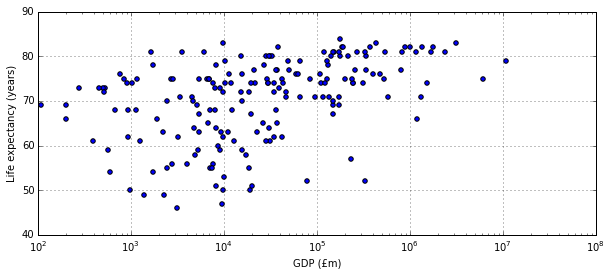

In [9]:
%matplotlib inline
gdpVsLife.plot(x=GDP, y=LIFE, kind='scatter', grid=True, logx=True, figsize=(10, 4))

The plot shows there is no clear correlation: there are rich countries with low life expectancy, poor countries with high expectancy, and countries with around 10 thousand (10<sup>4</sup>) million pounds GDP have almost the full range of values, from below 50 to over 80 years. Towards the lower and higher end of GDP, the variation diminishes. Above 40 thousand million pounds of GDP (3rd tick mark to the right of 10<sup>4</sup>), most countries have an expectancy of 70 years or more, whilst below that threshold most countries' life expectancy is below 70 years. 

Comparing the 10 poorest countries and the 10 countries with the lowest life expectancy shows that total GDP is a rather crude measure. The population size should be taken into account for a more precise definiton of what 'poor' and 'rich' means. Furthermore, looking at the countries below, droughts and internal conflicts may also play a role in life expectancy. 

In [10]:
# the 10 countries with lowest GDP
gdpVsLife.sort(GDP).head(10)

,country,GDP (£m),Life expectancy (years)
88,Kiribati,108,69
142,Sao Tome and Principe,199,66
112,"Micronesia, Fed. Sts.",202,69
168,Tonga,277,73
37,Comoros,395,61
157,St. Vincent and the Grenadines,459,73
141,Samoa,509,73
180,Vanuatu,512,72
66,Grenada,534,73
61,"Gambia, The",570,59


In [11]:
# the 10 countries with lowest life expectancy
gdpVsLife.sort(LIFE).head(10)

,country,GDP (£m),Life expectancy (years)
147,Sierra Leone,3150,46
22,Botswana,9573,47
96,Lesotho,1373,49
160,Swaziland,2256,49
117,Mozambique,9878,50
32,Central African Republic,987,50
38,"Congo, Dem. Rep.",19182,50
33,Chad,8276,51
41,Cote d'Ivoire,19998,51
3,Angola,79349,52


## Conclusions

To sum up, there is no strong correlation between a country's wealth and the life expectancy of its inhabitants: there is often a wide variation of life expectancy for countries with similar GDP, countries with the lowest life expectancy are not the poorest countries, and countries with the highest expectancy are not the richest countries. Nevertheless there is some relationship, because the vast majority of countries with a life expectancy below 70 years is on the left half of the scatterplot.

Using the [NY.GDP.PCAP.PP.CD](http://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD) indicator, GDP per capita in current 'international dollars', would make for a better like-for-like comparison between countries, because it would take population and purchasing power into account. Using more specific data, like expediture on health, could also lead to a better analysis.

## Extending this further

This extension of the this project aims to answer the following question:

> To what extent do the ten countries with the highest GDP coincide with the ten countries with the longest life expectancy?


### My approach

My first approach is to look at the 10 richest counties, and the countries with the longest life expectancy.

We established earlier that there was no correlation between the GDP and life expectancy across the entire range of countries. I intend to see if this holds true for a smaller subset of the countries too

### Looking at the 10 richest countries

In [13]:
gdpVsLife.sort(GDP, ascending=False).head(10)

,country,GDP (£m),Life expectancy (years)
177,United States,10715999,79
35,China,6065182,75
84,Japan,3143957,83
63,Germany,2383906,81
59,France,1795953,82
176,United Kingdom,1711547,81
23,Brazil,1528722,74
82,Italy,1365665,82
139,Russian Federation,1328647,71
76,India,1189826,66


### Then looking at the ten longest living

In [15]:
gdpVsLife.sort(LIFE, ascending=False).head(10)

,country,GDP (£m),Life expectancy (years)
73,"Hong Kong SAR, China",176220,84
162,Switzerland,438042,83
84,Japan,3143957,83
75,Iceland,9838,83
81,Israel,185683,82
154,Spain,890253,82
161,Sweden,370359,82
148,Singapore,193157,82
82,Italy,1365665,82
7,Australia,997191,82


We can see that two out of the top 10 countries are both tables, specifcally, Japan and Italy.

In [33]:
tenRichest = gdpVsLife.sort(GDP, ascending=False).head(20)
tenlongestLiving = gdpVsLife.sort(LIFE, ascending=False).head(20)
merge(tenRichest, tenlongestLiving, on="country", how="inner")


,country,GDP (£m)_x,Life expectancy (years)_x,GDP (£m)_y,Life expectancy (years)_y
0,Japan,3143957,83,3143957,83
1,Germany,2383906,81,2383906,81
2,France,1795953,82,1795953,82
3,United Kingdom,1711547,81,1711547,81
4,Italy,1365665,82,1365665,82
5,Canada,1175231,81,1175231,81
6,Australia,997191,82,997191,82
7,Spain,890253,82,890253,82
8,Switzerland,438042,83,438042,83


#### Is there a correlation in the 10?

In [22]:
from scipy.stats import spearmanr

gdpColumn = tenRichest[GDP]
lifeColumn = tenlongestLiving[LIFE]
(correlation, pValue) = spearmanr(gdpColumn, lifeColumn)
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is 0.873862897505
It is statistically significant.


Among the top ten, the correlation is higher (_can you do this? I suspect using a smaller sample size, doesn't do you any favours..._)

### The outliers

There are outliers too, worth investigating:

> Which are the two countries in the right half of the plot (higher GDP) with life expectancy below 60 years? What factors could explain their lower life expectancy compared to countries with similar GDP? Hint: use the filtering techniques you learned in Week 2 to find the two countries.

To look at these'll filter the chart to only show counteis with a life expectancy below 60 years, then rank by GPD again.

First, we check their types, so we can filter 

In [27]:
gdpVsLife.dtypes

country                     object
GDP (£m)                   float64
Life expectancy (years)    float64
dtype: object

Next, we'll make a subset of `gdpVsLife`:


In [32]:
gdpVsLife[gdpVsLife[LIFE] < 60].sort(GDP, ascending=False).head(2)

,country,GDP (£m),Life expectancy (years)
125,Nigeria,329100,52
152,South Africa,233937,57


Nigeria is the most populous country in Africa, and South Africa is also one of the strongest economies. In both cases they are rich in resources (Oil for Nigeria, and and minerals for South Africa). Whether riches from natural resources translates into an equal society is another matter. South Africa is still recovering from apartheid, and Nigeria suffers from corruption.

## Revisiting this study

In my example, I had different results in the comments, because France was missing from my list.

Running an innerjoin in the entire

In [36]:
# France was mentioned in the comments. I just missed it. What a muppet!

merge(gdpVsLife.sort(GDP, ascending=False), gdpVsLife.sort(LIFE, ascending=False), on="country", how="inner").head(11)

,country,GDP (£m)_x,Life expectancy (years)_x,GDP (£m)_y,Life expectancy (years)_y
0,United States,10715999,79,10715999,79
1,China,6065182,75,6065182,75
2,Japan,3143957,83,3143957,83
3,Germany,2383906,81,2383906,81
4,France,1795953,82,1795953,82
5,United Kingdom,1711547,81,1711547,81
6,Brazil,1528722,74,1528722,74
7,Italy,1365665,82,1365665,82
8,Russian Federation,1328647,71,1328647,71
9,India,1189826,66,1189826,66


### Hang on, am I just doing something stupid?

Sorting by one then the other doesn't work. We want to sort by GDP _and_ LIFE.

In [40]:
gdpVsLife.sort(GDP, ascending=False).sort(LIFE, ascending=False)

,country,GDP (£m),Life expectancy (years)
73,"Hong Kong SAR, China",176220,84
75,Iceland,9838,83
162,Switzerland,438042,83
84,Japan,3143957,83
161,Sweden,370359,82
59,France,1795953,82
81,Israel,185683,82
148,Singapore,193157,82
82,Italy,1365665,82
7,Australia,997191,82
